# Imports and inits consts

In [1]:
!rm -r ./reduce-mode-collapse-in-gan
!git clone https://github.com/ThViviani/reduce-mode-collapse-in-gan.git

import sys; sys.path.append('./reduce-mode-collapse-in-gan')

rm: cannot remove './reduce-mode-collapse-in-gan': No such file or directory
Cloning into 'reduce-mode-collapse-in-gan'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 308 (delta 32), reused 45 (delta 16), pack-reused 242 (from 1)
Receiving objects: 100% (308/308), 5.40 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [2]:
!pip install -r ./reduce-mode-collapse-in-gan/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━

In [6]:
import lightning as L
import torch
import torchvision
import torch.utils
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import torch_fidelity
import wandb
import gc
import pandas as pd

from PIL import Image
from torch.utils.data import Dataset
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer, seed_everything
from utils.utils import generate_some_examples

In [ ]:
N_STEPS = 300_000
DATASET_LEN = 50_000
BATCH_SIZE = 64
LATENT_SPACE_DIM = 128
WANDB_TOKEN = '' # input your wandb token
SEED = 999
MAX_EPOCHS = int(N_STEPS * BATCH_SIZE / DATASET_LEN)

seed_everything(SEED)

INFO: Seed set to 999


999

In [8]:
wandb.login(key=WANDB_TOKEN)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Preparing Cifar10 dataset and loaders

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

In [10]:
train_dataset = torchvision.datasets.CIFAR10('cifar10', download=True, train=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('cifar10', download=True, train=False, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 59055380.89it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


target:  6


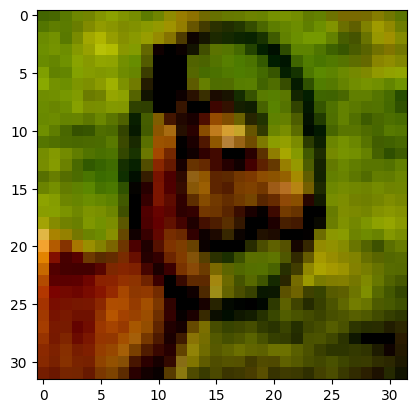

In [12]:
img, target = train_dataset[np.random.randint(0, len(train_dataset))]

print('target: ', train_dataset[0][1])
plt.imshow(img.permute(1, 2, 0))

In [13]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

In [14]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

# Experiments

In [15]:
from models.discriminators import CriticStackedMNIST
from models.generators import GeneratorStackedMNIST


b = torch.randn(BATCH_SIZE, LATENT_SPACE_DIM)
g = GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM)
print(g(b).shape)


d = CriticStackedMNIST(x_factor=4)
d(torch.randn(256, 3, 32, 32), return_features=True)[1].shape

torch.Size([64, 3, 32, 32])


torch.Size([256, 8, 4, 4])

In [16]:
from models.encoders import EncoderMNIST

e = EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2)

e(torch.randn(256, 3, 32, 32)).shape

torch.Size([256, 128])

In [17]:
train_dataset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [18]:
from utils.train_options import TrainOptions

train_options = TrainOptions(
    latent_dim=LATENT_SPACE_DIM,
    batch_size=BATCH_SIZE,
)

In [20]:
from trainers.neighbors_embedding_gan import NEVanilaGAN, NERpGAN
from trainers.dist_gan import DistVanilaGAN, DistRpGAN
from trainers.standard_gan import StandardGAN
from trainers.rp_gan import RpGAN
from models.discriminators import CriticMNIST
from datetime import datetime
from trainers.dp_gan import DpVanilaGan, DpRpGAN
from trainers.ne_gan_without_ae import NEVanilaGAN_hat, NERpGAN_hat


def create_model_fn(model_class, use_encoder=False, use_r1r2=False):
    def wrapper():
        if model_class.__name__.find('Rp') != -1:
            return model_class(
                critic=CriticStackedMNIST(x_factor=2),
                generator=GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM),
                encoder=EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2) if use_encoder else None,
                use_r1r2_penalty=use_r1r2,
                opt=train_options,
            )
        else:
            return model_class(
                critic=CriticStackedMNIST(x_factor=2),
                generator=GeneratorStackedMNIST(z_dim=LATENT_SPACE_DIM),
                encoder=EncoderMNIST(x_shape=(3, 32, 32), z_dim=LATENT_SPACE_DIM, kernel_size=3, stride=2) if use_encoder else None,
                opt=train_options,
            )
    return wrapper


EXPERIMENTS = {
    # 'DpVanilaGAN': create_model_fn(DpVanilaGan),
    # 'NEVanilaGAN': create_model_fn(NEVanilaGAN, use_encoder=True),
    # 'DistVanilaGAN': create_model_fn(DistVanilaGAN, use_encoder=True),
    # 'NEVanilaGAN_hat': create_model_fn(NEVanilaGAN_hat),
    'StandardGAN': create_model_fn(StandardGAN),
    # 'RpGAN': create_model_fn(RpGAN),
    # 'NERpGAN_hat': create_model_fn(NERpGAN_hat),
    # 'DistRpGAN': create_model_fn(DistRpGAN, use_encoder=True),
    # 'NERpGAN': create_model_fn(NERpGAN, use_encoder=True),
    # 'DpRpGAN': create_model_fn(DpRpGAN),
    # 'RpGAN_R1R2': create_model_fn(RpGAN, use_r1r2=True),
    # 'NERpGAN_hat+R1R2': create_model_fn(NERpGAN_hat, use_r1r2=True),
    # 'DistRpGAN+R1R2': create_model_fn(DistRpGAN, use_encoder=True, use_r1r2=True),
    # 'NERpGAN+R1R2': create_model_fn(NERpGAN, use_encoder=True, use_r1r2=True),
    # 'DpRpGAN+R1R2': create_model_fn(DpRpGAN, use_r1r2=True),
}

results = pd.DataFrame(columns=[
    'inception_score_mean',
    'inception_score_std',
    'frechet_inception_distance'
])

In [21]:
from utils.utils import regist_dataset_in_torch_fidelity

ROOT_TO_REGISTER_DATASET_FOR_FID = 'test_dataset'
regist_dataset_in_torch_fidelity(torchvision.datasets.CIFAR10, ROOT_TO_REGISTER_DATASET_FOR_FID)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Running NERpGAN+R1R2


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | critic    | CriticStackedMNIST    | 1.9 K  | train
1 | generator | GeneratorStackedMNIST | 175 K  | train
2 | encoder   | EncoderMNIST          | 1.6 M  | train
------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.915     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.


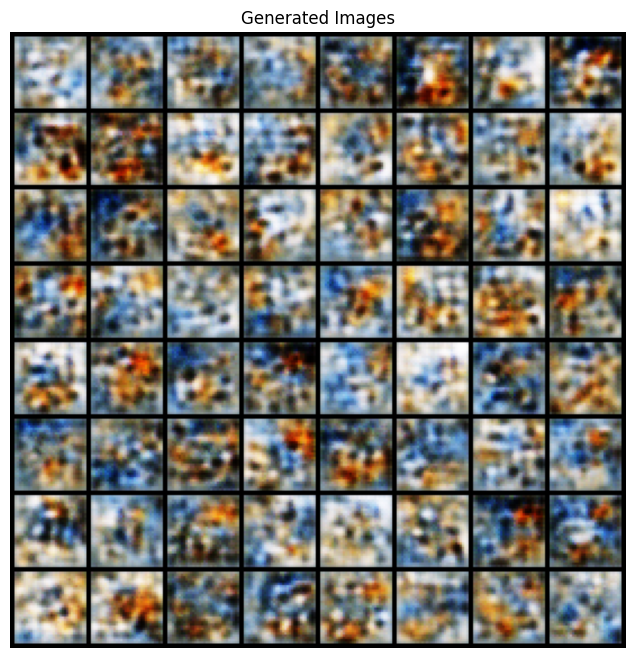

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 248MB/s]


100%|██████████| 170498071/170498071 [00:02<00:00, 79736957.20it/s]


Extracting /root/.cache/torch/fidelity_datasets/cifar-10-python.tar.gz to /root/.cache/torch/fidelity_datasets
{'inception_score_mean': 1.6313866662427905, 'inception_score_std': 0.017119061551116047, 'frechet_inception_distance': 372.33943722375346}
{'inception_score_mean': 1.6313866662427905, 'inception_score_std': 0.017119061551116047, 'frechet_inception_distance': 372.33943722375346}


d_grads_mean,█▇▂▃▅▄▅▂▄▄▆█▆▃▃▃▂▄▃▃▅▅▄▅▁▃▆▄▄▅▅
d_grads_std,█▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
e_grads_mean,▅▄▂█▆▅▄▆▆▅▁▇▆▅▄▆▅▂▂▅▅▅▆▆▅▄▆▅▆▆▅
e_grads_std,▂▃▃▅▇▅▆▃▃█▆▇▄▂▃▂▄▄▅▃▄▃▁▃▃▃▆▂▂▂▂
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████
g_grads_mean,▆█▄▄▃▃▄▂▃▁▂▃▂▂▂▃▂▁▂▂▂▂▁▂▂▂▂▁▂▁▁
g_grads_std,██▆▄▅▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
kl_loss,█▄▃▅▃▃▆▂▃▁▃▃▃▅▃▂▂▂▂▄▂▁▂▃▂▃▂▃▂▃▄
loss_ae,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
loss_d,█▄▄▄▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
loss_g,▅▄▃▁▅▅▄▄▆▅▅▆▇▆▆▆▇▇▇▇▇▇▇▇███████


In [22]:
from utils.utils import compute_metrics


for name, model_fn in EXPERIMENTS.items():
    print(f"Running {name}")

    wandb_logger = WandbLogger(
        project='CIFAR10_vkr',
        save_dir='',
        log_model=True,
        name=name + "_" + str(datetime.now())
    )

    trainer = L.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=wandb_logger,
        deterministic=True,
        default_root_dir=f"checkpoints/{name}",
    )

    model = model_fn()

    trainer.fit(model=model, train_dataloaders=train_loader)

    generate_some_examples(model.generator, BATCH_SIZE, LATENT_SPACE_DIM, model.device)
    metrics = compute_metrics(model, SEED, LATENT_SPACE_DIM, ROOT_TO_REGISTER_DATASET_FOR_FID)
    
    print(metrics)
    results.loc[name] = metrics

    wandb.finish()

    EXPERIMENTS[name] = model

    # del model
    del trainer
    del wandb_logger
    gc.collect()
    torch.cuda.empty_cache()

In [23]:
results

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,modes_covered,KL
NERpGAN+R1R2,NaN,NaN
